In [ ]:
#main

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.3161 - val_loss: 0.2747
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2693 - val_loss: 0.2413
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2409 - val_loss: 0.2079
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2047 - val_loss: 0.1721
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1754 - val_loss: 0.1328
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1296 - val_loss: 0.0974
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1032 - val_loss: 0.1057
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1103 - val_loss: 0.1042
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1033 - val_loss: 0.0896
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0921 - val_loss: 0.0889
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0932 - val_loss: 0.0932
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0954 - val_loss: 0.0959
Epoch 13/20

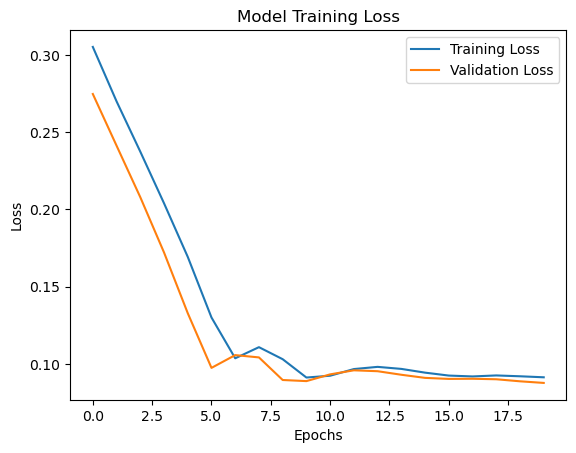

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data
data_path = 'data/main/sensor_data.csv'  # Update with the actual path
data = pd.read_csv(data_path)

# Assume 'CO' column contains CO concentrations
data['co_concentration'] = data['co_concentration'].values.astype(float)

# Normalize the CO data (0 to 1 scale)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['co_concentration']])

# Prepare data for LSTM model (predict next 6 hours)
def create_dataset(data, time_step=72, forecast_hours=6):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_hours):
        X.append(data[i:(i + time_step), 0])
        y.append(data[(i + time_step):(i + time_step + forecast_hours), 0])
    return np.array(X), np.array(y)

# Prepare X and y for LSTM model
X, y = create_dataset(data_scaled)

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=6))  # Output is 6 hours prediction

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict CO concentrations for the next 6 hours
predictions = model.predict(X_test)

# Reverse scaling for predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Display predicted values for the first test sample
print("Predicted CO concentrations for the next 6 hours:")
for i, prediction in enumerate(predictions[0]):
    print(f"Hour {i + 1}: {prediction:.2f} ppm")

# Fan control logic based on predicted CO concentrations
def control_fan(sensor_1_value, sensor_2_value):
    # Define CO concentration thresholds for fan control
    threshold_1 = 0.5  # Low threshold (ppm)
    threshold_2 = 1.0  # High threshold (ppm)
    
    # Initial fan settings
    fan_speed = 'OFF'
    fan_direction = 'NONE'
    
    # Control fan based on the sensor values
    if sensor_1_value > threshold_2 or sensor_2_value > threshold_2:
        fan_speed = 'HIGH'
        if sensor_1_value > sensor_2_value:
            fan_direction = 'TOWARDS SENSOR 1'
        else:
            fan_direction = 'TOWARDS SENSOR 2'
    elif sensor_1_value > threshold_1 or sensor_2_value > threshold_1:
        fan_speed = 'LOW'
        if sensor_1_value > sensor_2_value:
            fan_direction = 'TOWARDS SENSOR 1'
        else:
            fan_direction = 'TOWARDS SENSOR 2'
    else:
        fan_speed = 'OFF'
        fan_direction = 'NONE'
    
    # Output the fan control actions
    return fan_speed, fan_direction

# Example: Get predictions for the next 6 hours and control fan based on those predictions
for i in range(6):
    # Use predicted values as CO concentrations from the sensors
    sensor_1_value = predictions[0][i]
    sensor_2_value = predictions[0][i]  # Assuming both sensors have similar readings
    
    # Get the fan control decision based on the predicted CO levels
    fan_speed, fan_direction = control_fan(sensor_1_value, sensor_2_value)
    print(f"Predicted CO concentration for hour {i + 1}: {sensor_1_value:.2f} ppm")
    print(f"Fan Speed: {fan_speed}, Fan Direction: {fan_direction}")
    print()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
#data producer for 2 sensors

In [8]:
import pandas as pd
import numpy as np

# Parameters for synthetic data generation
num_samples = 150  # Total number of samples (lines)
look_back = 72  # The number of hours to consider as a look-back window

# Simulate CO concentration data for Sensor 1 (immediate response)
np.random.seed(42)
sensor_1_data = np.random.rand(num_samples)  # Random values between 0 and 1

# Simulate Sensor 2 data with a delay (shifted by 3 batches)
sensor_2_data = np.roll(sensor_1_data, shift=3)  # Shift by 3 to simulate delayed response

# Make sure the first 3 entries for sensor 2 are NaN (simulating the delay)
sensor_2_data[:3] = np.nan

# Create a timestamp for each sample (daily)
timestamps = pd.date_range(start='2025-01-01', periods=num_samples, freq='H')

# Create DataFrame with timestamps and sensor data
data = pd.DataFrame({
    'timestamp': timestamps,
    'sensor_1_co_concentration': sensor_1_data,
    'sensor_2_co_concentration': sensor_2_data
})

# Save the DataFrame to CSV
data.to_csv('data/delay/sensor_delay.csv', index=False)

# Print the first few rows of the generated data
print(data.head())


            timestamp  sensor_1_co_concentration  sensor_2_co_concentration
0 2025-01-01 00:00:00                   0.374540                        NaN
1 2025-01-01 01:00:00                   0.950714                        NaN
2 2025-01-01 02:00:00                   0.731994                        NaN
3 2025-01-01 03:00:00                   0.598658                   0.374540
4 2025-01-01 04:00:00                   0.156019                   0.950714


/var/folders/kk/glz4pw_x1r5668xj51q9p6zw0000gn/T/ipykernel_7795/978074105.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2025-01-01', periods=num_samples, freq='H')


In [ ]:
#comparison of 2 sensor values

Epoch 1/20


/var/folders/kk/glz4pw_x1r5668xj51q9p6zw0000gn/T/ipykernel_9010/2589026410.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sensor_data['sensor_2_co_concentration'].fillna(method='bfill', inplace=True)
/var/folders/kk/glz4pw_x1r5668xj51q9p6zw0000gn/T/ipykernel_9010/2589026410.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_data['sensor_2_co_concentration'].fillna(method='bfill', inplace=True)
/opt/anaconda3/lib/python3.12/s

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.5547 - val_loss: 0.4464
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4395 - val_loss: 0.3462
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3542 - val_loss: 0.2590
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2524 - val_loss: 0.1829
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1885 - val_loss: 0.1205
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1150 - val_loss: 0.0869
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0914 - val_loss: 0.1081
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1190 - val_loss: 0.1276
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1232 - val_loss: 0.1109
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1092 - val_loss: 0.0933
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0936 - val_loss: 0.0881
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0878 - val_loss: 0.0894
Epoch 13/20

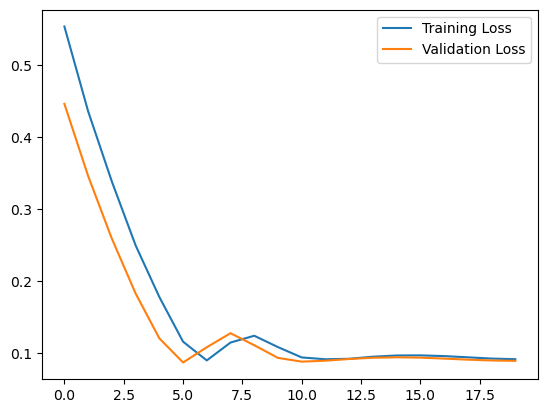

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted CO concentrations for the next 6 hours: 0.49364354686833856
Last Sensor 1 CO concentration: 0.2786464642366114
Last Sensor 2 CO concentration: 0.6095643339798968
No action required. Air quality is safe.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv('data/delay/sensor_delay.csv')

# Convert timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Use only the sensor data columns
sensor_data = data[['sensor_1_co_concentration', 'sensor_2_co_concentration']]

# Fill NaN values in the second sensor (delayed response) with previous values (or use any strategy)
sensor_data['sensor_2_co_concentration'].fillna(method='bfill', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sensor_data)

# Prepare the data for training the LSTM
look_back = 72  # 72 hours as look-back
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i])  # Use last 72 hours of data as features
    y.append(scaled_data[i, 0])  # Predict the sensor 1 concentration

X, y = np.array(X), np.array(y)

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer with one unit for CO concentration prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions for the next 6 hours
predictions = model.predict(X_test[-1:].reshape(1, X_test.shape[1], X_test.shape[2]))

# Inverse transform to get the predicted concentration in original scale
predicted_co_concentration = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 1)))))
print("Predicted CO concentrations for the next 6 hours:", predicted_co_concentration[0, 0])

# Fan Control logic
def fan_control(sensor_1_value, sensor_2_value):
    if sensor_1_value > 0.7 and sensor_2_value > 0.7:
        return "Switch on the fan at full speed. Direction: Both sides."
    elif sensor_1_value > 0.7:
        return "Switch on the fan at medium speed. Direction: Towards the sensor 1 side."
    elif sensor_2_value > 0.7:
        return "Switch on the fan at medium speed. Direction: Towards the sensor 2 side."
    else:
        return "No action required. Air quality is safe."

# Compare the last sensor values to decide on fan control
last_sensor_1_value = sensor_data['sensor_1_co_concentration'].iloc[-1]
last_sensor_2_value = sensor_data['sensor_2_co_concentration'].iloc[-1]

print("Last Sensor 1 CO concentration:", last_sensor_1_value)
print("Last Sensor 2 CO concentration:", last_sensor_2_value)

# Fan control decision based on both sensor values
fan_decision = fan_control(last_sensor_1_value, last_sensor_2_value)
print(fan_decision)


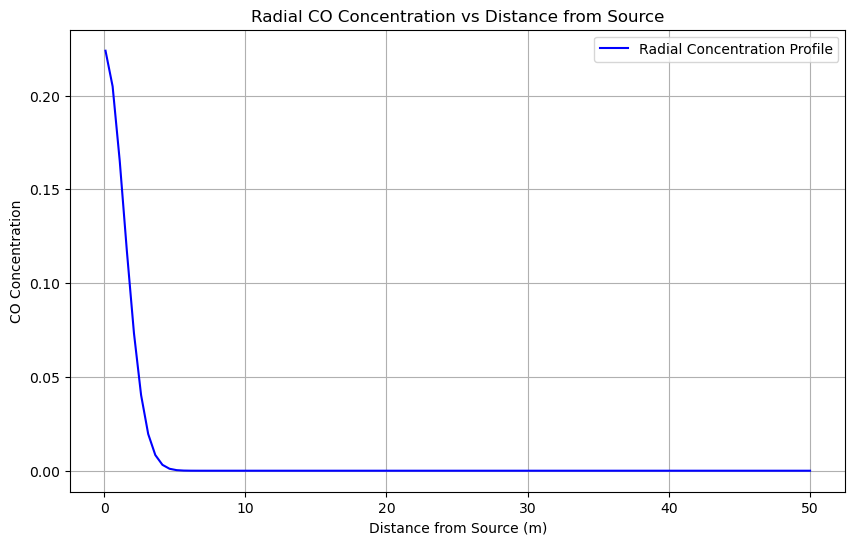

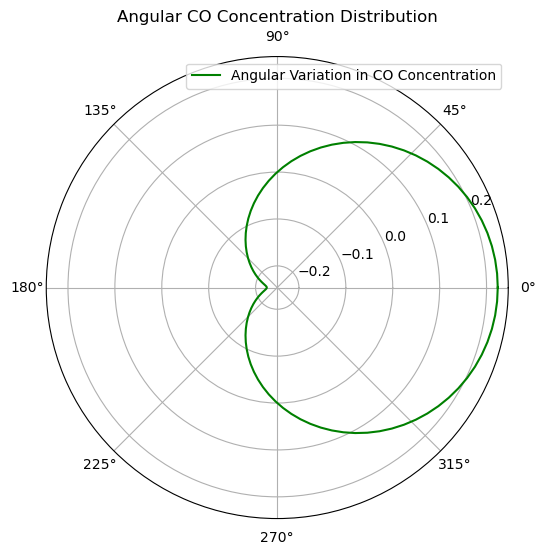

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
D = 0.01  # Diffusion coefficient (m^2/s)
M = 10  # Total amount of CO (mass) released
t = 100  # Time in seconds

# Create an array for the radial distance
r = np.linspace(0.1, 50, 100)  # Radial distance from the source (0.1m to 50m)

# Calculate the concentration based on the diffusion equation
C_r = (M / (4 * np.pi * D * t)**(3/2)) * np.exp(-r**2 / (4 * D * t))

# Plot for r (Radial concentration profile)
plt.figure(figsize=(10, 6))
plt.plot(r, C_r, label="Radial Concentration Profile", color="blue")
plt.title("Radial CO Concentration vs Distance from Source")
plt.xlabel("Distance from Source (m)")
plt.ylabel("CO Concentration")
plt.legend()
plt.grid(True)
plt.show()

# Create a plot for angular concentration variation (θ)
theta = np.linspace(0, 2 * np.pi, 100)  # Angle (0 to 2pi for full circle)

# Assuming uniform diffusion in all directions for simplicity
C_theta = C_r[0] * np.cos(theta)  # Just a representation of how it might look in terms of direction

# Plot for θ (Angular variation in concentration)
plt.figure(figsize=(10, 6))
plt.polar(theta, C_theta, label="Angular Variation in CO Concentration", color="green")
plt.title("Angular CO Concentration Distribution")
plt.legend()
plt.show()


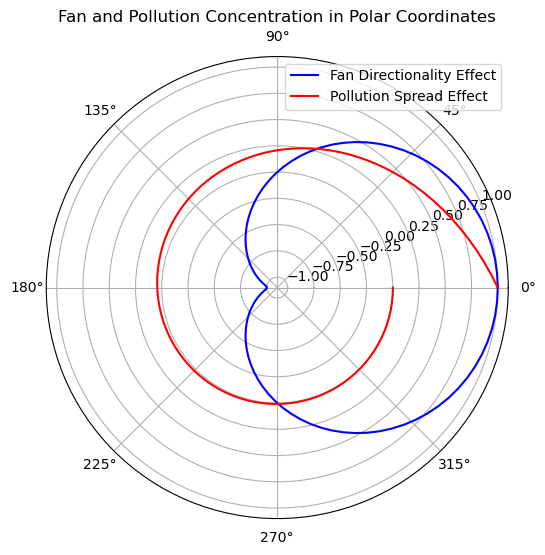

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for the model
D = 0.01  # Diffusion coefficient (m^2/s)
M = 10  # Total amount of CO (mass) released
t = 100  # Time in seconds

# Create an array for the radial distance r
r = np.linspace(0.1, 50, 100)  # Radial distance from the fan (0.1m to 50m)

# Calculate concentration based on the diffusion equation (radial)
C_r = (M / (4 * np.pi * D * t)**(3/2)) * np.exp(-r**2 / (4 * D * t))

# Create an array for the angular direction θ
theta = np.linspace(0, 2 * np.pi, 100)  # Angle (0 to 2pi for full circle)

# Assume the fan is directed along θ = 0, and pollution is higher along θ = π
# Fan's effect on concentration (boosting in the θ=0 direction)
C_fan_theta = C_r[0] * np.cos(theta)  # Fan influence at angle θ

# Pollution's natural spread along θ=π
C_pollution_theta = C_r[0] * np.exp(-theta)  # Simulate pollution spread

# Normalize both for comparison
C_fan_theta_normalized = C_fan_theta / np.max(np.abs(C_fan_theta))
C_pollution_theta_normalized = C_pollution_theta / np.max(C_pollution_theta)

# Plot the polar graph
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, C_fan_theta_normalized, label="Fan Directionality Effect", color="blue")
ax.plot(theta, C_pollution_theta_normalized, label="Pollution Spread Effect", color="red")
ax.set_title("Fan and Pollution Concentration in Polar Coordinates")
ax.legend(loc="upper right")
plt.show()


In [ ]:
#fan & pollution graph

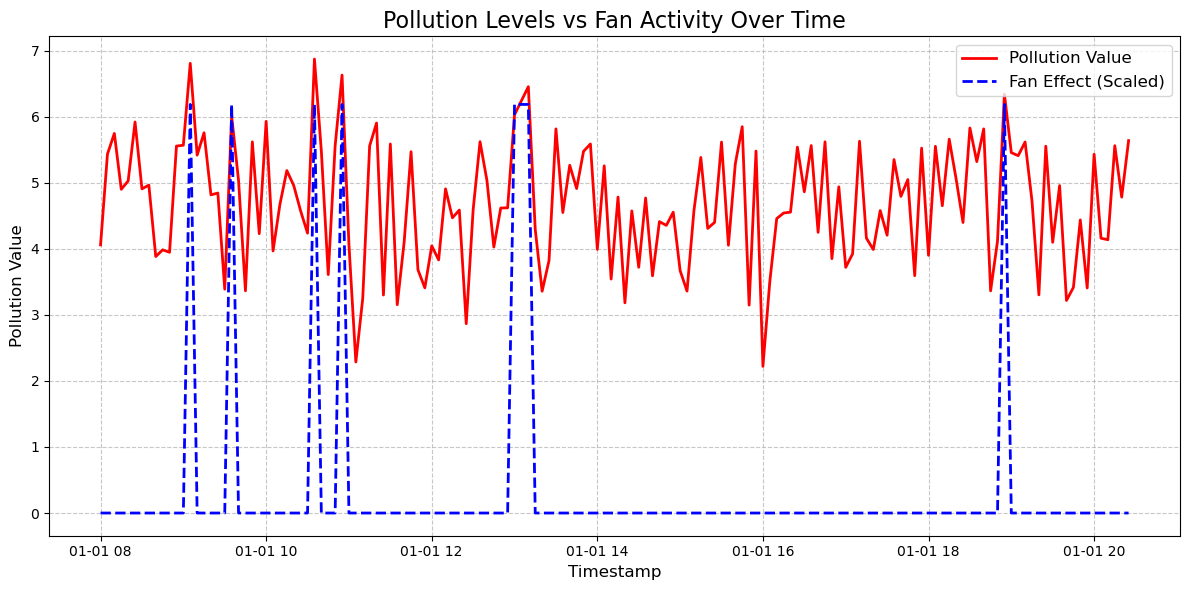

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the file 'data/main/sensor_data.csv' contains the following:
# Columns: 'timestamp', 'sensor1', 'sensor2', 'fan_status', 'pollution_value'

# Load the data
file_path = "data/main/sensor_data_with_fan.csv"
data = pd.read_csv(file_path)

# Parse the timestamp column
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Plot the pollution value and fan activity
plt.figure(figsize=(12, 6))

# Pollution levels
plt.plot(data.index, data['pollution_value'], label='Pollution Value', color='red', linewidth=2)

# Fan status (scaled for visualization)
fan_effect = data['fan_status'] * data['pollution_value'].max() * 0.9  # Scale for overlaying
plt.plot(data.index, fan_effect, label='Fan Effect (Scaled)', color='blue', linestyle='--', linewidth=2)

# Customize the plot
plt.title('Pollution Levels vs Fan Activity Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Pollution Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# fan values data producer

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters for data generation
num_samples = 150
start_time = datetime(2025, 1, 1, 8, 0, 0)  # Starting timestamp
time_interval = timedelta(minutes=5)  # Time interval between samples

# Generate timestamps
timestamps = [start_time + i * time_interval for i in range(num_samples)]

# Simulate sensor1 and sensor2 values (pollution levels)
sensor1 = np.random.normal(5, 1, num_samples).clip(0, 10)  # Simulated data near source
sensor2 = sensor1 - np.random.normal(0.5, 0.2, num_samples).clip(0, 1)  # Slightly lower readings for farther sensor
sensor2 = sensor2.clip(0, 10)

# Simulate pollution value (aggregate or average of sensor1 and sensor2)
pollution_value = (sensor1 + sensor2) / 2

# Simulate fan status based on pollution threshold
fan_status = (pollution_value > 6).astype(int)  # Fan turns on if pollution > 6

# Create a DataFrame
data = pd.DataFrame({
    'timestamp': timestamps,
    'sensor1': sensor1,
    'sensor2': sensor2,
    'fan_status': fan_status,
    'pollution_value': pollution_value
})

# Save to CSV
file_path = 'data/main/sensor_data_with_fan.csv'
data.to_csv(file_path, index=False)

file_path


'data/main/sensor_data_with_fan.csv'